<h1 align=center><font size = 5>RECOMMENDATION SYSTEM USING RESTRICTED BOLTZMANN MACHINE</font></h1>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

sn.set(font_scale = 1.4)

In [3]:
movies_df = pd.read_csv('./Resources/Data/ml-1m/movies.dat', sep = '::', header = None)
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df = pd.read_csv('Resources/Data/ml-1m/ratings.dat', sep = '::', header = None)
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [6]:
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
print('Number of movies:', len(movies_df))
print('Number of users:', len(np.unique(np.array(list(ratings_df['UserID'])))))

Number of movies: 3883
Number of users: 6040


In [9]:
movies_df['List Index'] = movies_df.index
movies_df.head()

,MovieID,Title,Genres,List Index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3
4,5,Father of the Bride Part II (1995),Comedy,4


In [10]:
merged_df = movies_df.merge(ratings_df, on = 'MovieID')
merged_df = merged_df.drop('Timestamp', axis = 1).drop('Title', axis = 1).drop('Genres', axis = 1)
merged_df.head()

,MovieID,List Index,UserID,Rating
0,1,0,1,5
1,1,0,6,4
2,1,0,8,4
3,1,0,9,5
4,1,0,10,5


In [11]:
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

,MovieID,List Index,Rating
UserID,,,
1,1,0,5
2,21,20,1
3,104,102,4
4,260,257,5
5,6,5,2


In [12]:
amountOfUsedUsers = 1000
trX = []

for userID, curUser in userGroup:
    temp = [0] * len(movies_df)
    for num, movie in curUser.iterrows():
        temp[movie['List Index']] = movie['Rating'] / 5.0
    trX.append(temp)
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1

In [13]:
hiddenUnits = 20
visibleUnits = len(movies_df)
vb = tf.placeholder("float", [visibleUnits])
hb = tf.placeholder("float", [hiddenUnits])
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

In [14]:
#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [15]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.cast(tf.shape(v0)[0], dtype = tf.float32)
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [16]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [17]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Epoch 1: Error = 0.12393278
Epoch 2: Error = 0.08284252
Epoch 3: Error = 0.06831879
Epoch 4: Error = 0.060235918
Epoch 5: Error = 0.051449545
Epoch 6: Error = 0.0475192
Epoch 7: Error = 0.0453251
Epoch 8: Error = 0.044218715
Epoch 9: Error = 0.043546658
Epoch 10: Error = 0.04300407
Epoch 11: Error = 0.04247459
Epoch 12: Error = 0.04182497
Epoch 13: Error = 0.04104383
Epoch 14: Error = 0.04087907
Epoch 15: Error = 0.040437125


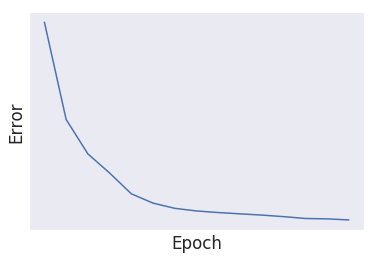

In [18]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_nb}))
    print('Epoch ' + str(i + 1) + ': Error = ' + str(errors[-1]))
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:
#Selecting the input user
inputUser = [trX[75]]
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict = {
    v0 : inputUser,
    W : prv_w,
    hb : prv_hb
})
rec = sess.run(vv1, feed_dict = {
    hh0 : feed,
    W : prv_w,
    vb : prv_vb
})
scored_movies_df_75 = movies_df
scored_movies_df_75["Recommendation Score"] = rec[0]
scored_movies_df_75.sort_values(["Recommendation Score"], ascending = False).head(20)

,MovieID,Title,Genres,List Index,Recommendation Score
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.875532
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.707599
523,527,Schindler's List (1993),Drama|War,523,0.652799
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.615263
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.586230
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.562676
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.558775
293,296,Pulp Fiction (1994),Crime|Drama,293,0.558545
2928,2997,Being John Malkovich (1999),Comedy,2928,0.552483
1656,1704,Good Will Hunting (1997),Drama,1656,0.441613


In [20]:
merged_df.iloc[75]

MovieID         1
List Index      0
UserID        215
Rating          4
Name: 75, dtype: int64

In [21]:
movies_df_75 = merged_df[merged_df['UserID']==215]
movies_df_75.head()

,MovieID,List Index,UserID,Rating
75,1,0,215,4
11873,24,23,215,5
67543,260,257,215,5
82782,316,313,215,4
97063,356,352,215,5


In [22]:
merged_df_75 = scored_movies_df_75.merge(movies_df_75, on = 'MovieID', how = 'outer')
merged_df_75 = merged_df_75.drop('List Index_y', axis = 1).drop('UserID', axis = 1)

In [23]:
merged_df_75.sort_values(["Recommendation Score"], ascending = False).head(20)

,MovieID,Title,Genres,List Index_x,Recommendation Score,Rating
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.875532,NaN
604,608,Fargo (1996),Crime|Drama|Thriller,604,0.707599,NaN
523,527,Schindler's List (1993),Drama|War,523,0.652799,NaN
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.615263,NaN
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller,589,0.586230,NaN
315,318,"Shawshank Redemption, The (1994)",Drama,315,0.562676,NaN
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,1575,0.558775,4.0
293,296,Pulp Fiction (1994),Crime|Drama,293,0.558545,NaN
2928,2997,Being John Malkovich (1999),Comedy,2928,0.552483,NaN
1656,1704,Good Will Hunting (1997),Drama,1656,0.441613,NaN
